**Loading Dataset**
-

In [25]:
!cp -r /kaggle/input/rice-leafs-disease-dataset /kaggle/working

In [ ]:
!pip install torch-geometric


**Loading needed libraries or frameworks**
-

In [3]:
import os
import cv2
import math
import random
import pickle
import shutil
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage import color, graph
from skimage.segmentation import slic

import torch
import torch.nn.functional as F
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader

from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool, global_max_pool
from torch_geometric.nn import BatchNorm, LayerNorm, PairNorm

**Data visualization**
-

In [5]:
def show_sample_dataset(root_dir, num_images=5):
    """Display sample images from dataset"""
    plant_types = os.listdir(root_dir)
    for plant in plant_types:
        plant_path = os.path.join(root_dir, plant)
        if not os.path.isdir(plant_path):
            continue
        print(f"\nShowing samples from plant: {plant}")
        disease_types = os.listdir(plant_path)
        for disease in disease_types:
            disease_path = os.path.join(plant_path, disease)
            if not os.path.isdir(disease_path):
                continue
            img_files = [f for f in os.listdir(disease_path) if f.lower().endswith((".jpg", ".png", ".jpeg"))]
            samples = random.sample(img_files, min(len(img_files), num_images))
            print(f"Disease: {disease} ({len(samples)} samples)")
            for fname in samples:
                img_path = os.path.join(disease_path, fname)
                img = cv2.imread(img_path)
                if img is None:
                    print(f"Warning: Could not read image {img_path}")
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                plt.figure(figsize=(4, 4))
                plt.imshow(img)
                plt.title(f"{plant} - {disease}")
                plt.axis('off')
                plt.show()

Split Dataset
-

In [21]:
def split_dataset(root_dir, output_dir, train_ratio=0.8, test_ratio=0.2, max_per_class=300, seed=42):
    """
    Split dataset into train and test sets with stratification.
    Only use up to `max_per_class` images per class.
    """
    random.seed(seed)
    
    # Create output directories
    os.makedirs(output_dir, exist_ok=True)
    for split in ['train', 'validation']:
        os.makedirs(os.path.join(output_dir, split), exist_ok=True)
    
    classes = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    
    for cls in classes:
        cls_folder = os.path.join(root_dir, cls)
        
        # Create class directories in each split
        for split in ['train', 'validation']:
            os.makedirs(os.path.join(output_dir, split, cls), exist_ok=True)
        
        # Get and limit images
        images = [f for f in os.listdir(cls_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        images = images[:max_per_class] if len(images) > max_per_class else images
        random.shuffle(images)
        
        # Calculate split indices
        train_idx = int(len(images) * train_ratio)
        
        # Split images
        train_imgs = images[:train_idx]
        valid_imgs = images[train_idx:]
        
        # Copy images to respective folders
        for split, img_list in zip(['train', 'valid'], [train_imgs, valid_imgs]):
            for img_name in img_list:
                src = os.path.join(cls_folder, img_name)
                dst = os.path.join(output_dir, split, cls, img_name)
                shutil.copy2(src, dst)
    
    # Print split statistics
    train_count = sum(len(os.listdir(os.path.join(output_dir, 'train', cls))) for cls in classes)
    valid_count = sum(len(os.listdir(os.path.join(output_dir, 'validation', cls))) for cls in classes)
    total = train_count + valid_count
    
    print(f"✅ Dataset split completed (limited to {max_per_class} images per class):")
    print(f"  Train: {train_count} images ({train_count/total*100:.1f}%)")
    print(f"  Validation: {valid_count} images ({valid_count/total*100:.1f}%)")


**SLIC - Simple Linear Iterative Clustering**
-

In [7]:
def extract_segments_using_slic(image, num_segments=50, compactness=15):
    """
    Extract super-pixel segments using SLIC algorithm with improved parameters
    for leaf disease classification
    """
    # Convert to LAB color space for better segmentation of leaf patterns
    img_lab = color.rgb2lab(image)
    
    # Apply SLIC with adjusted parameters for capturing disease patterns
    segments = slic(
        img_lab, 
        n_segments=num_segments, 
        compactness=compactness, 
        sigma=2, 
        start_label=0,
        channel_axis=2
    )
    
    return segments


**Enhanced feature extraction**
-

In [8]:
def obtain_enhanced_node_features(image, segments):
    """
    Enhanced feature extraction for each segment including color and texture
    """
    node_features = []
    
    # Convert to multiple color spaces for richer features
    img_hsv = cv2.cvtColor(
        (image * 255).astype(np.uint8), 
        cv2.COLOR_RGB2HSV
    ).astype(np.float32) / 255.0
    
    # Get maximum segment ID
    max_segment_id = segments.max()
    
    for i in range(max_segment_id + 1):
        mask = segments == i
        if np.any(mask):  # Make sure segment is not empty
            # Extract RGB features
            rgb_features = image[mask].mean(axis=0)  # Shape: (3,)
            
            # Extract HSV features
            hsv_features = img_hsv[mask].mean(axis=0)  # Shape: (3,)
            
            # Extract simple texture features (standard deviation of colors)
            texture_rgb = np.std(image[mask], axis=0) if mask.sum() > 1 else np.zeros(3)
            
            # Calculate segment size (normalized by image size)
            segment_size = mask.sum() / (image.shape[0] * image.shape[1])
            
            # Combine features
            features = np.concatenate([
                rgb_features,          # RGB mean (3)
                hsv_features,          # HSV mean (3)
                texture_rgb,           # RGB std (3)
                [segment_size]         # Size (1)
            ])
            
            node_features.append(features)
        else:
            # Default features for empty segments
            node_features.append(np.zeros(10))
    
    return np.array(node_features)



**RAG -  Region Adjacency Graph**
-


In [9]:
def construct_region_adjacency_graph(image, segments):
    """
    Construct region adjacency graph from segments with improved edge weighting
    """
    # Create region adjacency graph - this now uses edge weights based on color difference
    rag = graph.rag_mean_color(image, segments)
    
    # Construct edge index and edge attributes for PyG
    edge_index = []
    edge_attr = []
    
    for n1, n2, data in rag.edges(data=True):
        # Add edge in both directions (undirected graph)
        edge_index.append([n1, n2])
        edge_index.append([n2, n1])
        
        # Extract edge weight (color similarity)
        weight = data.get('weight', 1.0)
        
        # Add normalized weight as edge attribute
        norm_weight = np.exp(-weight / 10.0)  # Exponential decay for large color differences
        edge_attr.append([norm_weight])
        edge_attr.append([norm_weight])
    
    # Handle empty edge case
    if not edge_index:
        edge_index = [[0, 0], [0, 0]]  # Self-loop as fallback
        edge_attr = [[1.0], [1.0]]
        
    return np.array(edge_index).T, np.array(edge_attr)


**Image to graph SLIC + CLAHE + RAG **
-

In [10]:
def preprocessing_image_to_graph(image_path, num_segments=50, compactness=15):
    """
    Convert an image to a graph representation using enhanced SLIC segmentation
    with richer node features and edge attributes
    """
    # 1. Load image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Failed to load image: {image_path}")
    
    # 2. Preprocess image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # 3. Apply CLAHE for contrast enhancement
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    lab_planes = list(cv2.split(lab))  # Convert to list to allow assignment
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab = cv2.merge(lab_planes)
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    
    
    # 4. Resize image
    img = cv2.resize(img, (128, 128))
    
    # 5. Normalize the image
    img = img / 255.0
    
    # 6. Extract segments using SLIC
    segments = extract_segments_using_slic(img, num_segments, compactness)
    
    # 7. Obtain enhanced node features
    node_features = obtain_enhanced_node_features(img, segments)
    node_features = torch.tensor(node_features, dtype=torch.float)
    
    # 8. Construct region adjacency graph with edge attributes
    edge_index, edge_attr = construct_region_adjacency_graph(img, segments)
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    
    return node_features, edge_index, edge_attr

**Store RAG features in pickle files for training**
-


In [11]:
def save_precomputed_graphs(root_dir, output_dir, num_segments=50, compactness=15):
    """Precompute and save enhanced graph representations of all images"""
    os.makedirs(output_dir, exist_ok=True)
    
    if os.path.isdir(os.path.join(root_dir, "train")) and os.path.isdir(os.path.join(root_dir, "test")):
        # Dataset is already split into train and test
        splits = ["train", "test"]
    else:
        # Dataset is not split yet
        splits = [""]
    
    for split in splits:
        split_dir = os.path.join(root_dir, split) if split else root_dir
        split_output_dir = os.path.join(output_dir, split) if split else output_dir
        os.makedirs(split_output_dir, exist_ok=True)
        
        # Process each class
        classes = [d for d in os.listdir(split_dir) if os.path.isdir(os.path.join(split_dir, d))]
        
        for cls in classes:
            cls_dir = os.path.join(split_dir, cls)
            cls_output_dir = os.path.join(split_output_dir, cls)
            os.makedirs(cls_output_dir, exist_ok=True)
            
            # Get list of images
            img_files = [f for f in os.listdir(cls_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            print(f"Processing {len(img_files)} images from {cls} ({split})")
            
            for img_file in tqdm(img_files):
                img_path = os.path.join(cls_dir, img_file)
                graph_file = os.path.join(cls_output_dir, f"{os.path.splitext(img_file)[0]}.pkl")
                
                try:
                    # Convert image to graph with enhanced features
                    x, edge_index, edge_attr = preprocessing_image_to_graph(img_path, num_segments, compactness)
                    
                    # Save the graph
                    with open(graph_file, 'wb') as f:
                        pickle.dump((x, edge_index, edge_attr), f)
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")
    
    print(f"✅ Enhanced precomputed graphs have been saved to {output_dir}")


**Edge augmentations**
-

In [12]:
def edge_augmentation(data, p_add=0.1, p_remove=0.1):
    """
    Edge augmentation based on Algorithm 1:
    - With probability p_add, add random edges
    - With probability p_remove, remove random edges
    
    Args:
        data: PyG Data object
        p_add: Probability of adding edges
        p_remove: Probability of removing edges
    
    Returns:
        Augmented PyG Data object
    """
    # Initialize: E_aug ← E
    edge_index = data.edge_index.clone()
    edge_attr = data.edge_attr.clone() if hasattr(data, 'edge_attr') else None
    num_nodes = data.num_nodes
    
    # If random probability < p_add then add edges
    if random.random() < p_add and num_nodes > 1:
        # Generate multiple random edges (more efficient)
        num_edges_to_add = max(1, int(edge_index.size(1) * 0.05))  # Add 5% more edges
        for _ in range(num_edges_to_add):
            # Generate random edge
            u = random.randint(0, num_nodes - 1)
            v = random.randint(0, num_nodes - 1)
            
            # Avoid self-loops
            if u != v:
                # Add edge: E_aug ← E_aug ∪ e_new
                new_edge = torch.tensor([[u, v], [v, u]], dtype=torch.long, device=edge_index.device)
                edge_index = torch.cat([edge_index, new_edge.t()], dim=1)
                
                # Add edge attributes if they exist
                if edge_attr is not None:
                    # Use random edge attributes similar to existing ones
                    if edge_attr.size(0) > 0:
                        rand_idx = random.randint(0, edge_attr.size(0) - 1)
                        new_attr = edge_attr[rand_idx].clone()
                        # Add some noise to attributes
                        new_attr = new_attr * (0.9 + 0.2 * torch.rand_like(new_attr))
                        new_attr = torch.stack([new_attr, new_attr])
                        edge_attr = torch.cat([edge_attr, new_attr], dim=0)
    
    # If random probability < p_remove then remove edges
    if random.random() < p_remove and edge_index.size(1) > 2:  # Ensure we have edges to remove
        # Remove multiple edges
        num_edges_to_remove = max(1, int(edge_index.size(1) * 0.05))  # Remove 5% of edges
        
        # For undirected graphs, ensure we don't disconnect the graph
        # Create a simple connectivity check by counting unique nodes in edges
        # This isn't a full connectivity check but helps preserve graph structure
        num_unique_edges = edge_index.size(1) // 2
        if num_unique_edges > num_edges_to_remove:
            edges_to_remove = set(random.sample(range(num_unique_edges), num_edges_to_remove))
            
            # Create a mask to keep all edges except the selected ones and their reverse
            mask = torch.ones(edge_index.size(1), dtype=torch.bool, device=edge_index.device)
            for edge_idx in edges_to_remove:
                mask[2*edge_idx] = False
                mask[2*edge_idx+1] = False
            
            # E_aug ← E_aug \ e_remove
            edge_index = edge_index[:, mask]
            if edge_attr is not None:
                edge_attr = edge_attr[mask]
    
    # Update the data object with augmented edge index and attributes
    data.edge_index = edge_index
    if edge_attr is not None:
        data.edge_attr = edge_attr
    
    return data

class GraphAugmentation(object):
    """Combine multiple graph augmentation techniques"""
    def __init__(self, p_edge=0.5):
        self.p_edge = p_edge
    
    def __call__(self, data):
        # Apply edge augmentation with probability p_edge
        if random.random() < self.p_edge:
            data = edge_augmentation(data, p_add=0.1, p_remove=0.1)

         
        return data


Data Loader
-

In [13]:
#################################
# 2. IMPROVED DATA LOADING & AUGMENTATION #
#################################

class LeafGraphDataset(Dataset):
    def __init__(self, root_dir, precomputed_dir=None, transform=None, use_precomputed=False):
        super().__init__(root=None, transform=transform)
        self.root_dir = root_dir
        self.precomputed_dir = precomputed_dir
        self.transform = transform
        self.use_precomputed = use_precomputed
        self.data_list = []
        self.label_map = {}
        self.class_samples = {}  # To track class balance
        
        # Process dataset
        classes = sorted(os.listdir(root_dir))
        for idx, cls in enumerate(classes):
            cls_path = os.path.join(root_dir, cls)
            if not os.path.isdir(cls_path):
                continue
                
            self.label_map[cls] = idx
            self.class_samples[idx] = 0  # Initialize counter
            print(f"Class {cls} -> Label {idx}")
            
            if self.use_precomputed:
                # Load precomputed graphs
                precomputed_cls_path = os.path.join(precomputed_dir, cls)
                if not os.path.exists(precomputed_cls_path):
                    print(f"Warning: Precomputed directory {precomputed_cls_path} not found")
                    continue
                
                graph_files = [f for f in os.listdir(precomputed_cls_path) if f.endswith('.pkl')]
                for graph_file in graph_files:
                    graph_path = os.path.join(precomputed_cls_path, graph_file)
                    self.data_list.append((graph_path, idx, True))  # True indicates precomputed
                    self.class_samples[idx] += 1
            else:
                # Use original images
                img_files = [f for f in os.listdir(cls_path) 
                            if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
                
                for img_name in img_files:
                    img_path = os.path.join(cls_path, img_name)
                    self.data_list.append((img_path, idx, False))  # False indicates not precomputed
                    self.class_samples[idx] += 1
        
        # Print class distribution
        total_samples = len(self.data_list)
        print("\nClass distribution:")
        for cls, idx in self.label_map.items():
            count = self.class_samples[idx]
            pct = count / total_samples * 100
            print(f"  {cls}: {count} samples ({pct:.1f}%)")
        
        print(f"\nLoaded {len(self.data_list)} {'graphs' if use_precomputed else 'images'} with {len(self.label_map)} classes")

    def len(self):
        return len(self.data_list)

    def get(self, idx):
        file_path, label, is_precomputed = self.data_list[idx]
        
        try:
            if is_precomputed:
                # Load precomputed graph
                with open(file_path, 'rb') as f:
                    data = pickle.load(f)
                    
                # Unpack based on whether edge_attr was included in precomputation
                if len(data) == 3:
                    x, edge_index, edge_attr = data
                else:
                    x, edge_index = data
                    # Create default edge attributes if not present
                    num_edges = edge_index.shape[1]
                    edge_attr = torch.ones((num_edges, 1), dtype=torch.float)
            else:
                # Process image on-the-fly
                x, edge_index, edge_attr = preprocessing_image_to_graph(file_path)
            
            # Create PyG Data object
            y = torch.tensor([label], dtype=torch.long)
            data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
            
            # Apply transform if available
            if self.transform is not None:
                data = self.transform(data)
                
            return data
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            # Return a simple fallback data object
            x = torch.ones((10, 10), dtype=torch.float)
            edge_index = torch.tensor([[0, 1, 1, 2], [1, 0, 2, 1]], dtype=torch.long)
            edge_attr = torch.ones((4, 1), dtype=torch.float)
            y = torch.tensor([label], dtype=torch.long)
            return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    
    def __len__(self):
        return self.len()
    
    def __getitem__(self, idx):
        return self.get(idx)


**Weight initialization**
-


In [14]:
class WeightInitialization(object):
    """Enhanced weight initialization for the model using He initialization"""
    @staticmethod
    def apply(model):
        for m in model.modules():
            if isinstance(m, torch.nn.Linear):
                # He initialization using uniform distribution as per Equation 1
                fan_in = m.in_features
                bound = math.sqrt(6.0 / fan_in)
                torch.nn.init.uniform_(m.weight, -bound, bound)
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias)
            
            elif isinstance(m, GCNConv):
                if hasattr(m, 'lin') and m.lin is not None:
                    # For GCNConv, determine input features
                    if hasattr(m.lin, 'in_features'):
                        fan_in = m.lin.in_features
                    else:
                        # Fallback if in_features is not directly accessible
                        fan_in = m.lin.weight.size(1)
                    
                    bound = math.sqrt(6.0 / fan_in)
                    torch.nn.init.uniform_(m.lin.weight, -bound, bound)
                    if m.lin.bias is not None:
                        torch.nn.init.zeros_(m.lin.bias)
            
            elif isinstance(m, GATConv):
                # Handle GAT source linear transformation
                if hasattr(m, 'lin_src') and m.lin_src is not None:
                    if hasattr(m.lin_src, 'weight') and m.lin_src.weight is not None:
                        if hasattr(m.lin_src, 'in_features'):
                            fan_in = m.lin_src.in_features
                        else:
                            # Fallback to weight shape
                            fan_in = m.lin_src.weight.size(1)
                        
                        bound = math.sqrt(6.0 / fan_in)
                        torch.nn.init.uniform_(m.lin_src.weight, -bound, bound)
                        if m.lin_src.bias is not None:
                            torch.nn.init.zeros_(m.lin_src.bias)
                
                # Handle GAT target linear transformation if present
                if hasattr(m, 'lin_dst') and m.lin_dst is not None:
                    if hasattr(m.lin_dst, 'weight') and m.lin_dst.weight is not None:
                        if hasattr(m.lin_dst, 'in_features'):
                            fan_in = m.lin_dst.in_features
                        else:
                            fan_in = m.lin_dst.weight.size(1)
                        
                        bound = math.sqrt(6.0 / fan_in)
                        torch.nn.init.uniform_(m.lin_dst.weight, -bound, bound)
                        if m.lin_dst.bias is not None:
                            torch.nn.init.zeros_(m.lin_dst.bias)
                
                # Initialize attention weights if present
                if hasattr(m, 'att') and m.att is not None:
                    if hasattr(m, 'heads'):
                        # For multi-head attention, use head dimension
                        fan_in = m.heads
                    else:
                        fan_in = 1
                    
                    bound = math.sqrt(6.0 / fan_in)
                    torch.nn.init.uniform_(m.att, -bound, bound)




**Define Model Architechture**
-

In [15]:

#######################################
# GCN Block with number_of_layers = 2 #
#######################################
class GraphConvolutionBlock(torch.nn.Module):
    """Enhanced Graph Convolutional block with residual connections"""
    def __init__(self, in_channels, hidden_channels, use_edge_attr=True):
        super(GraphConvolutionBlock, self).__init__()
        self.use_edge_attr = use_edge_attr

        # GCN layers
        self.gcn1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.gcn2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)

        

    def forward(self, x, edge_index, edge_attr=None):
        identity = x

        # First GCN layer
        x = self.gcn1(x, edge_index)
        x = self.bn1(x)
        x = F.elu(x)

        
        # Second GCN layer
        x = self.gcn2(x, edge_index)
        x = self.bn2(x)
        x = F.elu(x)

        return x


#######################################
# GAT Block with number_of_layers = 2 #
#######################################


class GraphAttentionBlock(torch.nn.Module):
    """Enhanced Graph Attention block with residual connections"""
    def __init__(self, in_channels, hidden_channels, heads=2, use_edge_attr=True):
        super(GraphAttentionBlock, self).__init__()
        self.use_edge_attr = use_edge_attr

        # GAT layers
        self.gat1 = GATConv(in_channels, hidden_channels // heads, heads=heads)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.gat2 = GATConv(hidden_channels, hidden_channels // heads, heads=heads)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)



    def forward(self, x, edge_index, edge_attr=None):
        identity = x

        # First GAT layer
        x = self.gat1(x, edge_index)
        x = self.bn1(x)
        x = F.elu(x)
        

        # Second GAT layer
        x = self.gat2(x, edge_index)
        x = self.bn2(x)
        x = F.elu(x)

        return x


###################
# Classifer layer #
###################

class EnhancedClassifier(torch.nn.Module):
    """Enhanced Classification layer with multi-scale features"""
    def __init__(self, in_channels, hidden_channels, num_classes):
        super(EnhancedClassifier, self).__init__()
        
        # First fully-connected layer
        self.fc1 = torch.nn.Linear(in_channels, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        
        # Second fully-connected layer
        self.fc2 = torch.nn.Linear(hidden_channels, hidden_channels // 2)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels // 2)
        
        # Output layer
        self.output = torch.nn.Linear(hidden_channels // 2, num_classes)
        
    def forward(self, x):
        # First layer
        x = self.fc1(x)
        x = self.bn1(x)
        
        # Second layer
        x = self.fc2(x)
        x = self.bn2(x)
        
        x = F.leaky_relu(x, 0.2)
        
        # Output layer
        return self.output(x)


###############
# Final Model #
###############

class HybridGCNGATModel(torch.nn.Module):
    """
    Enhanced hybrid model combining GCN and GAT layers with residual connections
    for plant disease classification from graph representations
    """
    def __init__(self, num_node_features, num_classes, hidden_channels=512, 
                 use_edge_attr=True, gcn_layers=1, gat_layers=1):
        super(HybridGCNGATModel, self).__init__()

        self.use_edge_attr = use_edge_attr
        self.num_node_features = num_node_features
        self.num_classes = num_classes
        
        # Feature transformation layer
        self.feature_transform = torch.nn.Sequential(
            torch.nn.Linear(num_node_features, hidden_channels),
            torch.nn.BatchNorm1d(hidden_channels),
            torch.nn.LeakyReLU(0.2),
        )
        
        # GCN blocks
        self.gcn_blocks = torch.nn.ModuleList()
        for i in range(gcn_layers):
            self.gcn_blocks.append(
                GraphConvolutionBlock(hidden_channels, hidden_channels, use_edge_attr)
            )
            
        # GAT blocks
        self.gat_blocks = torch.nn.ModuleList()
        for i in range(gat_layers):
            self.gat_blocks.append(
                GraphAttentionBlock(hidden_channels, hidden_channels, heads=2, use_edge_attr=use_edge_attr)
            )
        
        # Global pooling
        self.global_pool = lambda x, batch: torch.cat([
            global_mean_pool(x, batch),
            global_max_pool(x, batch)
        ], dim=1)
        
        # Final classifier
        pool_size = hidden_channels * 2  # Mean + Max pooling
        self.classifier = EnhancedClassifier(pool_size, hidden_channels, num_classes)
        
        # Initialize weights
        WeightInitialization.apply(self)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        edge_attr = data.edge_attr if hasattr(data, 'edge_attr') and self.use_edge_attr else None
        
        # Feature transformation
        x = self.feature_transform(x)
        

        # Apply GCN blocks
        for gcn_block in self.gcn_blocks:
            x = gcn_block(x, edge_index, edge_attr)
        
        # Apply GAT blocks
        for gat_block in self.gat_blocks:
            x = gat_block(x, edge_index, edge_attr)
        
        # Global pooling
        x = self.global_pool(x, batch)
        
        # Classification
        x = self.classifier(x)
        
        return x

    def summary(self):
        print("========== Hybrid GCN GAT Model Summary ==========")
        print(f"Input features: {self.num_node_features}")
        print(f"Hidden channels: {self.gcn_blocks[0].gcn1.in_channels if self.gcn_blocks else 'N/A'} → {self.gcn_blocks[0].gcn1.out_channels if self.gcn_blocks else 'N/A'}")
        print(f"Use edge attributes: {self.use_edge_attr}")
        print(f"GCN layers: {len(self.gcn_blocks)}")
        print(f"GAT layers: {len(self.gat_blocks)}")
        print(f"Pooling type: Global Mean + Max")
        print(f"Classifier input size: {self.classifier.fc1.in_features}")
        print(f"Number of classes: {self.num_classes}")
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")
        print("===============================================")

**Lossfunciton - Crossentropy**
-

In [16]:
class CrossEntropyLoss(torch.nn.Module):
    """
    Custom Cross-Entropy Loss implementation following the mathematical formula:
    Cross-Entropy Loss = -∑∑y_ij log(p_ij)
    
    Where:
    - y represents the true distribution of the labels
    - p represents the predicted distribution of the labels
    - i ranges from 1 to N (number of samples)
    - j ranges from 1 to C (number of classes)
    """
    def __init__(self, reduction='mean', epsilon=1e-12):
        super(CrossEntropyLoss, self).__init__()
        self.reduction = reduction
        self.epsilon = epsilon  # Small constant to avoid log(0)
    
    def forward(self, inputs, targets):
        """
        Args:
            inputs (torch.Tensor): Raw logits from the model, shape (N, C)
            targets (torch.Tensor): Ground truth class indices, shape (N,)
                                   or one-hot encoded targets, shape (N, C)
        
        Returns:
            torch.Tensor: Calculated cross-entropy loss
        """
        # Get batch size and number of classes
        N = inputs.size(0)
        C = inputs.size(1)
        
        # Convert logits to probabilities using softmax
        probs = F.softmax(inputs, dim=1)
        
        # Add small epsilon to avoid log(0)
        probs = probs + self.epsilon
        
        # If targets are class indices, convert to one-hot encoding
        if targets.dim() == 1:
            targets_one_hot = torch.zeros_like(probs)
            targets_one_hot.scatter_(1, targets.unsqueeze(1), 1)
        else:
            targets_one_hot = targets
        
        # Calculate cross-entropy loss according to the formula
        # -∑∑y_ij log(p_ij)
        log_probs = torch.log(probs)
        loss = -torch.sum(targets_one_hot * log_probs, dim=1)
        
        # Apply reduction
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:  # 'none'
            return loss

**Train - Evaluation function**
--

In [17]:
#######################################
# 5. TRAINING UTILITIES AND EVALUATION #
#######################################
def train_one_epoch(model, loader, optimizer, loss_fn, device):
    """Train model for one epoch"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    # Use tqdm for progress bar
    for data in tqdm(loader, desc="Training"):
        data = data.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        out = model(data)
        loss = loss_fn(out, data.y.squeeze())
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Track metrics
        total_loss += loss.item() * data.num_graphs
        pred = out.argmax(dim=1)
        correct += int((pred == data.y.squeeze()).sum())
        total += data.num_graphs
    
    # Calculate average loss and accuracy
    avg_loss = total_loss / total
    accuracy = correct / total
    
    return avg_loss, accuracy


def evaluate(model, loader, loss_fn, device):
    """Evaluate model test set"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data in tqdm(loader, desc="Evaluating"):
            data = data.to(device)
            
            # Forward pass
            out = model(data)
            loss = loss_fn(out, data.y.squeeze())
            
            # Track metrics
            total_loss += loss.item() * data.num_graphs
            pred = out.argmax(dim=1)
            correct += int((pred == data.y.squeeze()).sum())
            total += data.num_graphs
            
            # Store predictions and targets for confusion matrix
            all_preds.append(pred.cpu())
            all_targets.append(data.y.squeeze().cpu())
    
    # Calculate average loss and accuracy
    avg_loss = total_loss / total
    accuracy = correct / total
    
    # Combine predictions and targets
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    
    return avg_loss, accuracy, all_preds, all_targets


def train_model(model, train_loader, val_loader, optimizer, scheduler, loss_fn, 
                device, num_epochs=100, patience=15, checkpoint_path='best_model.pt'):
    """
    Train model with early stopping and learning rate scheduling
    """
    best_val_acc = 0.0
    best_epoch = 0
    no_improve_count = 0
    
    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    for epoch in range(num_epochs):
        # Train one epoch
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
        
        # Evaluate on validation set
        val_loss, val_acc, _, _ = evaluate(model, val_loader, loss_fn, device)
        
        # Update learning rate
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()
        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Print progress
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        # Check if this is the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch
            no_improve_count = 0
            
            # Save the model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'val_loss': val_loss
            }, checkpoint_path)
            print(f"  New best model saved! Validation Accuracy: {val_acc:.4f}")
        else:
            no_improve_count += 1
            print(f"  No improvement for {no_improve_count} epochs. Best Val Acc: {best_val_acc:.4f} at epoch {best_epoch+1}")
        
        # Early stopping
        if no_improve_count >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs!")
            break
    
    # Load the best model
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded best model from epoch {checkpoint['epoch']+1} with validation accuracy {checkpoint['val_acc']:.4f}")
    
    return model, history

def plot_training_history(history):
    """Plot training loss and accuracy on the same axis with dual y-axes"""
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot training loss (left y-axis)
    color='tab:blue'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(history['train_loss'], label='Train Loss', color=color)
    ax1.plot(history['val_loss'], label ='Val Loss', color=color) 
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True)

    # Create a second y-axis for accuracy
    color='tab:orange'
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy', color=color)
    ax2.plot(history['train_acc'], label='Train Accuracy', color=color)
    ax2.plot(history['val_acc'], label='Test Accuracy', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    # Title and layout
    plt.title('Training Loss and Accuracy')
    fig.tight_layout()
    plt.show()


def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Plot confusion matrix for visualization
    """
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create a figure
    plt.figure(figsize=(12, 10))
    
    # Create a confusion matrix display
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    
    # Plot the confusion matrix
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    return cm


def evaluate_model(model, test_loader, device, label_map=None):
    """
    Complete model evaluation including confusion matrix and class-wise metrics
    """
    from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
    
    # Set model to evaluation mode
    model.eval()
    
    # Lists to store predictions and targets
    all_preds = []
    all_targets = []
    
    # Evaluation loop
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            
            # Forward pass
            out = model(data)
            pred = out.argmax(dim=1)
            
            # Store predictions and targets
            all_preds.append(pred.cpu())
            all_targets.append(data.y.squeeze().cpu())
    
    # Combine all predictions and targets
    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()
    
    # Calculate overall accuracy
    accuracy = accuracy_score(all_targets, all_preds)
    print(f"Overall Accuracy: {accuracy:.4f}")
    
    # Generate classification report
    if label_map:
        # Convert numeric labels to class names
        class_names = {v: k for k, v in label_map.items()}
        target_names = [class_names[i] for i in range(len(class_names))]
        
        # Print classification report
        print("\nClassification Report:")
        print(classification_report(all_targets, all_preds, target_names=target_names))
        
        # Calculate class-wise metrics
        precision, recall, f1, support = precision_recall_fscore_support(all_targets, all_preds)
        
        # Plot confusion matrix
        plot_confusion_matrix(all_targets, all_preds, target_names)
    else:
        # Print classification report with numeric labels
        print("\nClassification Report:")
        print(classification_report(all_targets, all_preds))
    
    # Return metrics
    return {
        'accuracy': accuracy,
        'predictions': all_preds,
        'targets': all_targets
    }




**Main Function**
-

Using device: cuda
Using existing precomputed graphs.
Creating datasets...
Class bacterial_leaf_blight -> Label 0
Class brown_spot -> Label 1
Class healthy -> Label 2
Class leaf_blast -> Label 3
Class leaf_scald -> Label 4
Class narrow_brown_spot -> Label 5

Class distribution:
  bacterial_leaf_blight: 350 samples (16.7%)
  brown_spot: 350 samples (16.7%)
  healthy: 350 samples (16.7%)
  leaf_blast: 350 samples (16.7%)
  leaf_scald: 350 samples (16.7%)
  narrow_brown_spot: 350 samples (16.7%)

Loaded 2100 graphs with 6 classes
Class bacterial_leaf_blight -> Label 0
Class brown_spot -> Label 1
Class healthy -> Label 2
Class leaf_blast -> Label 3
Class leaf_scald -> Label 4
Class narrow_brown_spot -> Label 5

Class distribution:
  bacterial_leaf_blight: 88 samples (16.7%)
  brown_spot: 88 samples (16.7%)
  healthy: 88 samples (16.7%)
  leaf_blast: 88 samples (16.7%)
  leaf_scald: 88 samples (16.7%)
  narrow_brown_spot: 88 samples (16.7%)

Loaded 528 graphs with 6 classes
Number of classe

Evaluating: 100%|██████████| 9/9 [00:00<00:00, 17.83it/s]


Epoch 1/100
  Train Loss: 0.7747, Train Acc: 0.7205
  Val Loss: 0.8490, Val Acc: 0.6705
  New best model saved! Validation Accuracy: 0.6705


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 32.61it/s]


Epoch 2/100
  Train Loss: 0.4772, Train Acc: 0.8152
  Val Loss: 0.4970, Val Acc: 0.8030
  New best model saved! Validation Accuracy: 0.8030


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 32.33it/s]


Epoch 3/100
  Train Loss: 0.3968, Train Acc: 0.8471
  Val Loss: 0.5668, Val Acc: 0.7689
  No improvement for 1 epochs. Best Val Acc: 0.8030 at epoch 2


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 29.58it/s]


Epoch 4/100
  Train Loss: 0.3914, Train Acc: 0.8405
  Val Loss: 0.5094, Val Acc: 0.8068
  New best model saved! Validation Accuracy: 0.8068


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 31.04it/s]


Epoch 5/100
  Train Loss: 0.3547, Train Acc: 0.8590
  Val Loss: 0.4645, Val Acc: 0.8068
  No improvement for 1 epochs. Best Val Acc: 0.8068 at epoch 4


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 29.25it/s]


Epoch 6/100
  Train Loss: 0.3215, Train Acc: 0.8743
  Val Loss: 0.6852, Val Acc: 0.7727
  No improvement for 2 epochs. Best Val Acc: 0.8068 at epoch 4


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 32.16it/s]


Epoch 7/100
  Train Loss: 0.3180, Train Acc: 0.8776
  Val Loss: 0.4160, Val Acc: 0.8561
  New best model saved! Validation Accuracy: 0.8561


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 31.75it/s]


Epoch 8/100
  Train Loss: 0.2774, Train Acc: 0.8967
  Val Loss: 0.5030, Val Acc: 0.8314
  No improvement for 1 epochs. Best Val Acc: 0.8561 at epoch 7


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 32.33it/s]


Epoch 9/100
  Train Loss: 0.2806, Train Acc: 0.8890
  Val Loss: 0.8337, Val Acc: 0.7367
  No improvement for 2 epochs. Best Val Acc: 0.8561 at epoch 7


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 31.71it/s]


Epoch 10/100
  Train Loss: 0.2456, Train Acc: 0.9067
  Val Loss: 0.3109, Val Acc: 0.8807
  New best model saved! Validation Accuracy: 0.8807


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 31.87it/s]


Epoch 11/100
  Train Loss: 0.2392, Train Acc: 0.9071
  Val Loss: 0.3054, Val Acc: 0.8769
  No improvement for 1 epochs. Best Val Acc: 0.8807 at epoch 10


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 31.62it/s]


Epoch 12/100
  Train Loss: 0.2242, Train Acc: 0.9119
  Val Loss: 0.8302, Val Acc: 0.7008
  No improvement for 2 epochs. Best Val Acc: 0.8807 at epoch 10


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 31.24it/s]


Epoch 13/100
  Train Loss: 0.2633, Train Acc: 0.9000
  Val Loss: 0.4266, Val Acc: 0.8428
  No improvement for 3 epochs. Best Val Acc: 0.8807 at epoch 10


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 29.32it/s]


Epoch 14/100
  Train Loss: 0.2380, Train Acc: 0.9119
  Val Loss: 0.3456, Val Acc: 0.8674
  No improvement for 4 epochs. Best Val Acc: 0.8807 at epoch 10


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 31.73it/s]


Epoch 15/100
  Train Loss: 0.2065, Train Acc: 0.9238
  Val Loss: 0.2550, Val Acc: 0.9034
  New best model saved! Validation Accuracy: 0.9034


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 31.51it/s]


Epoch 16/100
  Train Loss: 0.1906, Train Acc: 0.9243
  Val Loss: 0.3241, Val Acc: 0.8750
  No improvement for 1 epochs. Best Val Acc: 0.9034 at epoch 15


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 30.50it/s]


Epoch 17/100
  Train Loss: 0.2093, Train Acc: 0.9200
  Val Loss: 0.4331, Val Acc: 0.8220
  No improvement for 2 epochs. Best Val Acc: 0.9034 at epoch 15


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 32.12it/s]


Epoch 18/100
  Train Loss: 0.2007, Train Acc: 0.9200
  Val Loss: 0.3782, Val Acc: 0.8504
  No improvement for 3 epochs. Best Val Acc: 0.9034 at epoch 15


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 31.59it/s]


Epoch 19/100
  Train Loss: 0.2060, Train Acc: 0.9171
  Val Loss: 0.4117, Val Acc: 0.8598
  No improvement for 4 epochs. Best Val Acc: 0.9034 at epoch 15


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 32.08it/s]


Epoch 20/100
  Train Loss: 0.2072, Train Acc: 0.9252
  Val Loss: 0.2588, Val Acc: 0.8958
  No improvement for 5 epochs. Best Val Acc: 0.9034 at epoch 15


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 32.17it/s]


Epoch 21/100
  Train Loss: 0.1828, Train Acc: 0.9371
  Val Loss: 0.3917, Val Acc: 0.8617
  No improvement for 6 epochs. Best Val Acc: 0.9034 at epoch 15


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 32.07it/s]


Epoch 22/100
  Train Loss: 0.1931, Train Acc: 0.9300
  Val Loss: 0.2750, Val Acc: 0.9072
  New best model saved! Validation Accuracy: 0.9072


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 32.23it/s]


Epoch 23/100
  Train Loss: 0.1420, Train Acc: 0.9481
  Val Loss: 0.2870, Val Acc: 0.8958
  No improvement for 1 epochs. Best Val Acc: 0.9072 at epoch 22


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 31.95it/s]


Epoch 24/100
  Train Loss: 0.1662, Train Acc: 0.9381
  Val Loss: 0.2910, Val Acc: 0.9053
  No improvement for 2 epochs. Best Val Acc: 0.9072 at epoch 22


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 32.08it/s]


Epoch 25/100
  Train Loss: 0.1607, Train Acc: 0.9386
  Val Loss: 0.4464, Val Acc: 0.8371
  No improvement for 3 epochs. Best Val Acc: 0.9072 at epoch 22


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 32.42it/s]


Epoch 26/100
  Train Loss: 0.1471, Train Acc: 0.9452
  Val Loss: 0.2287, Val Acc: 0.9110
  New best model saved! Validation Accuracy: 0.9110


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 32.34it/s]


Epoch 27/100
  Train Loss: 0.1459, Train Acc: 0.9429
  Val Loss: 0.4623, Val Acc: 0.8674
  No improvement for 1 epochs. Best Val Acc: 0.9110 at epoch 26


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 32.61it/s]


Epoch 28/100
  Train Loss: 0.1350, Train Acc: 0.9471
  Val Loss: 0.3391, Val Acc: 0.8826
  No improvement for 2 epochs. Best Val Acc: 0.9110 at epoch 26


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 32.06it/s]


Epoch 29/100
  Train Loss: 0.1462, Train Acc: 0.9395
  Val Loss: 0.2999, Val Acc: 0.8996
  No improvement for 3 epochs. Best Val Acc: 0.9110 at epoch 26


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 31.92it/s]


Epoch 30/100
  Train Loss: 0.1406, Train Acc: 0.9529
  Val Loss: 0.3903, Val Acc: 0.8693
  No improvement for 4 epochs. Best Val Acc: 0.9110 at epoch 26


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 30.83it/s]


Epoch 31/100
  Train Loss: 0.1179, Train Acc: 0.9557
  Val Loss: 0.3377, Val Acc: 0.9015
  No improvement for 5 epochs. Best Val Acc: 0.9110 at epoch 26


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 32.14it/s]


Epoch 32/100
  Train Loss: 0.1457, Train Acc: 0.9495
  Val Loss: 0.2715, Val Acc: 0.8920
  No improvement for 6 epochs. Best Val Acc: 0.9110 at epoch 26


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 31.70it/s]


Epoch 33/100
  Train Loss: 0.1045, Train Acc: 0.9614
  Val Loss: 0.3804, Val Acc: 0.8826
  No improvement for 7 epochs. Best Val Acc: 0.9110 at epoch 26


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 31.55it/s]


Epoch 34/100
  Train Loss: 0.1173, Train Acc: 0.9595
  Val Loss: 0.3990, Val Acc: 0.8636
  No improvement for 8 epochs. Best Val Acc: 0.9110 at epoch 26


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 29.74it/s]


Epoch 35/100
  Train Loss: 0.1295, Train Acc: 0.9514
  Val Loss: 0.2435, Val Acc: 0.9205
  New best model saved! Validation Accuracy: 0.9205


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 31.53it/s]


Epoch 36/100
  Train Loss: 0.1394, Train Acc: 0.9471
  Val Loss: 0.3133, Val Acc: 0.8902
  No improvement for 1 epochs. Best Val Acc: 0.9205 at epoch 35


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 31.76it/s]


Epoch 37/100
  Train Loss: 0.1050, Train Acc: 0.9571
  Val Loss: 0.2385, Val Acc: 0.9242
  New best model saved! Validation Accuracy: 0.9242


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 31.39it/s]


Epoch 38/100
  Train Loss: 0.0709, Train Acc: 0.9738
  Val Loss: 0.1873, Val Acc: 0.9375
  New best model saved! Validation Accuracy: 0.9375


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 32.03it/s]


Epoch 39/100
  Train Loss: 0.0604, Train Acc: 0.9771
  Val Loss: 0.2220, Val Acc: 0.9337
  No improvement for 1 epochs. Best Val Acc: 0.9375 at epoch 38


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 31.00it/s]


Epoch 40/100
  Train Loss: 0.0522, Train Acc: 0.9786
  Val Loss: 0.2401, Val Acc: 0.9261
  No improvement for 2 epochs. Best Val Acc: 0.9375 at epoch 38


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 31.76it/s]


Epoch 41/100
  Train Loss: 0.0636, Train Acc: 0.9800
  Val Loss: 0.2246, Val Acc: 0.9318
  No improvement for 3 epochs. Best Val Acc: 0.9375 at epoch 38


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 32.00it/s]


Epoch 42/100
  Train Loss: 0.0440, Train Acc: 0.9852
  Val Loss: 0.2202, Val Acc: 0.9299
  No improvement for 4 epochs. Best Val Acc: 0.9375 at epoch 38


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 31.79it/s]


Epoch 43/100
  Train Loss: 0.0437, Train Acc: 0.9871
  Val Loss: 0.2354, Val Acc: 0.9299
  No improvement for 5 epochs. Best Val Acc: 0.9375 at epoch 38


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 32.38it/s]


Epoch 44/100
  Train Loss: 0.0527, Train Acc: 0.9800
  Val Loss: 0.3808, Val Acc: 0.8731
  No improvement for 6 epochs. Best Val Acc: 0.9375 at epoch 38


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 31.65it/s]


Epoch 45/100
  Train Loss: 0.0570, Train Acc: 0.9814
  Val Loss: 0.2291, Val Acc: 0.9186
  No improvement for 7 epochs. Best Val Acc: 0.9375 at epoch 38


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 32.10it/s]


Epoch 46/100
  Train Loss: 0.0412, Train Acc: 0.9890
  Val Loss: 0.2936, Val Acc: 0.9148
  No improvement for 8 epochs. Best Val Acc: 0.9375 at epoch 38


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 31.97it/s]


Epoch 47/100
  Train Loss: 0.0368, Train Acc: 0.9905
  Val Loss: 0.2741, Val Acc: 0.9148
  No improvement for 9 epochs. Best Val Acc: 0.9375 at epoch 38


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 31.22it/s]


Epoch 48/100
  Train Loss: 0.0351, Train Acc: 0.9876
  Val Loss: 0.2640, Val Acc: 0.9299
  No improvement for 10 epochs. Best Val Acc: 0.9375 at epoch 38


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 32.31it/s]


Epoch 49/100
  Train Loss: 0.0488, Train Acc: 0.9810
  Val Loss: 0.3214, Val Acc: 0.9129
  No improvement for 11 epochs. Best Val Acc: 0.9375 at epoch 38


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 28.39it/s]


Epoch 50/100
  Train Loss: 0.0346, Train Acc: 0.9890
  Val Loss: 0.2613, Val Acc: 0.9261
  No improvement for 12 epochs. Best Val Acc: 0.9375 at epoch 38


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 31.90it/s]


Epoch 51/100
  Train Loss: 0.0233, Train Acc: 0.9948
  Val Loss: 0.2339, Val Acc: 0.9451
  New best model saved! Validation Accuracy: 0.9451


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 32.03it/s]


Epoch 52/100
  Train Loss: 0.0193, Train Acc: 0.9948
  Val Loss: 0.2219, Val Acc: 0.9432
  No improvement for 1 epochs. Best Val Acc: 0.9451 at epoch 51


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 32.31it/s]


Epoch 53/100
  Train Loss: 0.0237, Train Acc: 0.9905
  Val Loss: 0.2481, Val Acc: 0.9280
  No improvement for 2 epochs. Best Val Acc: 0.9451 at epoch 51


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 32.01it/s]


Epoch 54/100
  Train Loss: 0.0218, Train Acc: 0.9929
  Val Loss: 0.2785, Val Acc: 0.9318
  No improvement for 3 epochs. Best Val Acc: 0.9451 at epoch 51


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 31.84it/s]


Epoch 55/100
  Train Loss: 0.0146, Train Acc: 0.9962
  Val Loss: 0.2498, Val Acc: 0.9337
  No improvement for 4 epochs. Best Val Acc: 0.9451 at epoch 51


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 30.98it/s]


Epoch 56/100
  Train Loss: 0.0265, Train Acc: 0.9905
  Val Loss: 0.2858, Val Acc: 0.9223
  No improvement for 5 epochs. Best Val Acc: 0.9451 at epoch 51


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 31.55it/s]


Epoch 57/100
  Train Loss: 0.0159, Train Acc: 0.9957
  Val Loss: 0.2575, Val Acc: 0.9318
  No improvement for 6 epochs. Best Val Acc: 0.9451 at epoch 51


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 32.24it/s]


Epoch 58/100
  Train Loss: 0.0197, Train Acc: 0.9943
  Val Loss: 0.2751, Val Acc: 0.9337
  No improvement for 7 epochs. Best Val Acc: 0.9451 at epoch 51


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 31.94it/s]


Epoch 59/100
  Train Loss: 0.0209, Train Acc: 0.9924
  Val Loss: 0.3088, Val Acc: 0.9299
  No improvement for 8 epochs. Best Val Acc: 0.9451 at epoch 51


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 31.89it/s]


Epoch 60/100
  Train Loss: 0.0144, Train Acc: 0.9957
  Val Loss: 0.2899, Val Acc: 0.9337
  No improvement for 9 epochs. Best Val Acc: 0.9451 at epoch 51


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 31.47it/s]


Epoch 61/100
  Train Loss: 0.0115, Train Acc: 0.9962
  Val Loss: 0.2829, Val Acc: 0.9299
  No improvement for 10 epochs. Best Val Acc: 0.9451 at epoch 51


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 32.20it/s]


Epoch 62/100
  Train Loss: 0.0120, Train Acc: 0.9976
  Val Loss: 0.2877, Val Acc: 0.9280
  No improvement for 11 epochs. Best Val Acc: 0.9451 at epoch 51


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 31.84it/s]


Epoch 63/100
  Train Loss: 0.0109, Train Acc: 0.9976
  Val Loss: 0.2682, Val Acc: 0.9470
  New best model saved! Validation Accuracy: 0.9470


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 32.32it/s]


Epoch 64/100
  Train Loss: 0.0102, Train Acc: 0.9976
  Val Loss: 0.2822, Val Acc: 0.9337
  No improvement for 1 epochs. Best Val Acc: 0.9470 at epoch 63


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 32.42it/s]


Epoch 65/100
  Train Loss: 0.0091, Train Acc: 0.9990
  Val Loss: 0.2791, Val Acc: 0.9337
  No improvement for 2 epochs. Best Val Acc: 0.9470 at epoch 63


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 31.74it/s]


Epoch 66/100
  Train Loss: 0.0071, Train Acc: 0.9986
  Val Loss: 0.2724, Val Acc: 0.9318
  No improvement for 3 epochs. Best Val Acc: 0.9470 at epoch 63


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 30.90it/s]


Epoch 67/100
  Train Loss: 0.0087, Train Acc: 0.9990
  Val Loss: 0.2891, Val Acc: 0.9318
  No improvement for 4 epochs. Best Val Acc: 0.9470 at epoch 63


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 30.90it/s]


Epoch 68/100
  Train Loss: 0.0098, Train Acc: 0.9986
  Val Loss: 0.2780, Val Acc: 0.9394
  No improvement for 5 epochs. Best Val Acc: 0.9470 at epoch 63


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 32.16it/s]


Epoch 69/100
  Train Loss: 0.0116, Train Acc: 0.9976
  Val Loss: 0.2755, Val Acc: 0.9432
  No improvement for 6 epochs. Best Val Acc: 0.9470 at epoch 63


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 31.96it/s]


Epoch 70/100
  Train Loss: 0.0062, Train Acc: 0.9986
  Val Loss: 0.2815, Val Acc: 0.9394
  No improvement for 7 epochs. Best Val Acc: 0.9470 at epoch 63


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 31.00it/s]


Epoch 71/100
  Train Loss: 0.0064, Train Acc: 0.9990
  Val Loss: 0.2902, Val Acc: 0.9413
  No improvement for 8 epochs. Best Val Acc: 0.9470 at epoch 63


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 31.27it/s]


Epoch 72/100
  Train Loss: 0.0054, Train Acc: 0.9986
  Val Loss: 0.2919, Val Acc: 0.9337
  No improvement for 9 epochs. Best Val Acc: 0.9470 at epoch 63


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 31.02it/s]


Epoch 73/100
  Train Loss: 0.0064, Train Acc: 0.9990
  Val Loss: 0.2817, Val Acc: 0.9337
  No improvement for 10 epochs. Best Val Acc: 0.9470 at epoch 63


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 31.51it/s]


Epoch 74/100
  Train Loss: 0.0040, Train Acc: 1.0000
  Val Loss: 0.2828, Val Acc: 0.9394
  No improvement for 11 epochs. Best Val Acc: 0.9470 at epoch 63


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 31.66it/s]


Epoch 75/100
  Train Loss: 0.0044, Train Acc: 0.9995
  Val Loss: 0.3016, Val Acc: 0.9356
  No improvement for 12 epochs. Best Val Acc: 0.9470 at epoch 63


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 32.25it/s]


Epoch 76/100
  Train Loss: 0.0042, Train Acc: 0.9995
  Val Loss: 0.2947, Val Acc: 0.9394
  No improvement for 13 epochs. Best Val Acc: 0.9470 at epoch 63


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 31.89it/s]


Epoch 77/100
  Train Loss: 0.0041, Train Acc: 0.9995
  Val Loss: 0.2965, Val Acc: 0.9413
  No improvement for 14 epochs. Best Val Acc: 0.9470 at epoch 63


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 32.02it/s]


Epoch 78/100
  Train Loss: 0.0061, Train Acc: 0.9986
  Val Loss: 0.3120, Val Acc: 0.9356
  No improvement for 15 epochs. Best Val Acc: 0.9470 at epoch 63


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 31.99it/s]


Epoch 79/100
  Train Loss: 0.0072, Train Acc: 0.9990
  Val Loss: 0.2918, Val Acc: 0.9394
  No improvement for 16 epochs. Best Val Acc: 0.9470 at epoch 63


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 32.49it/s]


Epoch 80/100
  Train Loss: 0.0039, Train Acc: 0.9995
  Val Loss: 0.2855, Val Acc: 0.9451
  No improvement for 17 epochs. Best Val Acc: 0.9470 at epoch 63


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 31.03it/s]


Epoch 81/100
  Train Loss: 0.0115, Train Acc: 0.9971
  Val Loss: 0.3004, Val Acc: 0.9299
  No improvement for 18 epochs. Best Val Acc: 0.9470 at epoch 63


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 31.17it/s]


Epoch 82/100
  Train Loss: 0.0063, Train Acc: 0.9981
  Val Loss: 0.3029, Val Acc: 0.9337
  No improvement for 19 epochs. Best Val Acc: 0.9470 at epoch 63


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 31.81it/s]
/tmp/ipykernel_31/1869092657.py:142: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoi

Epoch 83/100
  Train Loss: 0.0040, Train Acc: 0.9990
  Val Loss: 0.2981, Val Acc: 0.9413
  No improvement for 20 epochs. Best Val Acc: 0.9470 at epoch 63
Early stopping triggered after 83 epochs!
Loaded best model from epoch 63 with validation accuracy 0.9470


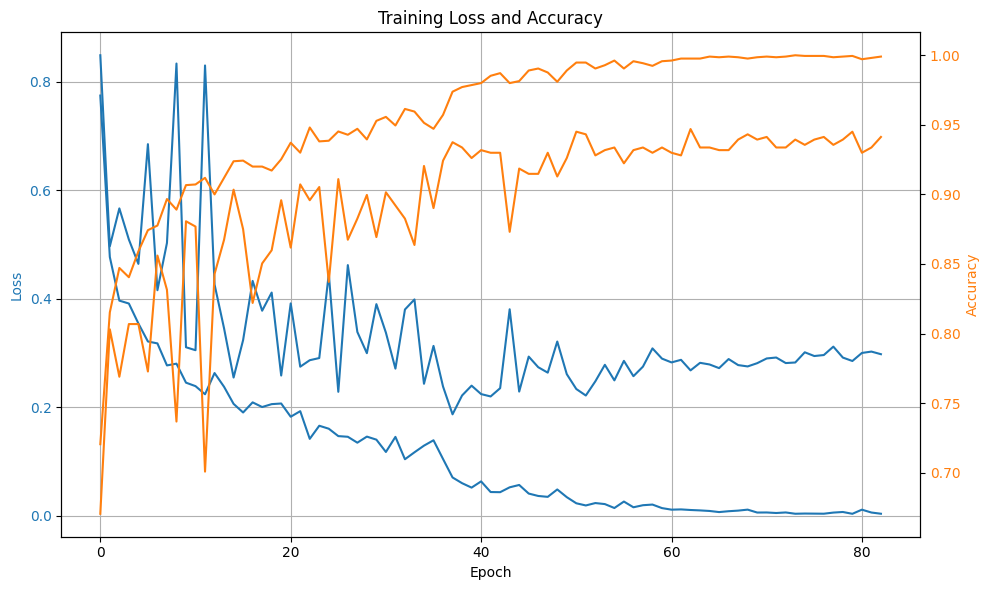


Evaluating model on test set...
Overall Accuracy: 0.9470

Classification Report:
                       precision    recall  f1-score   support

bacterial_leaf_blight       0.99      1.00      0.99        88
           brown_spot       0.94      0.86      0.90        88
              healthy       0.89      0.90      0.89        88
           leaf_blast       0.87      0.92      0.90        88
           leaf_scald       1.00      1.00      1.00        88
    narrow_brown_spot       1.00      1.00      1.00        88

             accuracy                           0.95       528
            macro avg       0.95      0.95      0.95       528
         weighted avg       0.95      0.95      0.95       528



<Figure size 1200x1000 with 0 Axes>

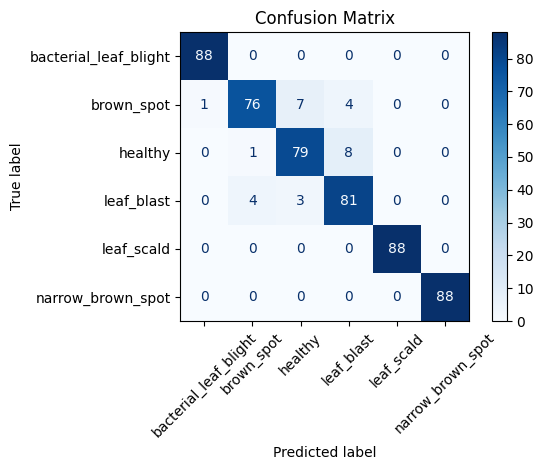

✅ Model evaluation completed with test accuracy: 0.9470


In [34]:
def main(dataset_root, output_dir, precomputed_dir=None, batch_size=32, hidden_channels=512,
         learning_rate=0.001, num_epochs=100, use_precomputed=True, precompute_only=False):
    """
    Main function to run the entire pipeline
    """
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    """
    # 1. Dataset Preparation
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Check if dataset is already split
    if not os.path.exists(os.path.join(output_dir, 'train')) or \
       not os.path.exists(os.path.join(output_dir, 'validation')):
        print("Splitting dataset into train and test sets...")
        split_dataset(dataset_root, output_dir)
    """
    # 2. Precompute graphs if needed
    if use_precomputed and precomputed_dir:
        precomputation_needed = False
        
        # Check if precomputed files exist
        for split in ['train', 'validation']:
            split_precomputed_dir = os.path.join(precomputed_dir, split)
            if not os.path.exists(split_precomputed_dir) or len(os.listdir(split_precomputed_dir)) == 0:
                precomputation_needed = True
                break
        
        if precomputation_needed:
            print("Precomputed graphs not found. Precomputing now...")
            if not os.path.exists(precomputed_dir):
                os.makedirs(precomputed_dir)
                
            for split in ['train', 'validation']:
                split_dir = os.path.join(output_dir, split)
                split_precomputed_dir = os.path.join(precomputed_dir, split)
                
                if not os.path.exists(split_precomputed_dir):
                    os.makedirs(split_precomputed_dir)
                
                # Only precompute if directory is empty
                if len(os.listdir(split_precomputed_dir)) == 0:
                    print(f"Processing {split} split...")
                    save_precomputed_graphs(split_dir, split_precomputed_dir)
                else:
                    print(f"Precomputed graphs for {split} already exist. Skipping.")
        else:
            print("Using existing precomputed graphs.")
    
    # Exit if only precomputing
    if precompute_only:
        print("Precomputation completed. Exiting...")
        return
    
    # 3. Create datasets
    print("Creating datasets...")
    # Data augmentation for training
    transform_train = GraphAugmentation(p_edge=0.5)
    
    # Create datasets
    train_dataset = LeafGraphDataset(
        os.path.join(output_dir, 'train'),
        os.path.join(precomputed_dir, 'train') if precomputed_dir else None,
        transform=transform_train,
        use_precomputed=use_precomputed
    )
    
    valid_dataset = LeafGraphDataset(
        os.path.join(output_dir, 'validation'),
        os.path.join(precomputed_dir, 'validation') if precomputed_dir else None,
        transform=None,
        use_precomputed=use_precomputed
    )
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
    
    num_classes = len(train_dataset.label_map)
    print(f"Number of classes: {num_classes}")
    
    # 4. Create model
    sample_data = train_dataset[0]
    num_node_features = sample_data.x.size(1)
    print(f"Number of node features: {num_node_features}")
    
    # Define model
    model = HybridGCNGATModel(
        num_node_features=num_node_features,
        num_classes = num_classes,
        hidden_channels=hidden_channels, 
        use_edge_attr=True,
        gcn_layers=1,            
        gat_layers=1          
    ).to(device)

    
    print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")

    model.summary()
    
    # 5. Set up training
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=10, verbose=True
    )

    # Use mixed loss for handling class imbalance
    loss_fn = CrossEntropyLoss()
    
    # 6. Train model
    model, history = train_model(
        model, train_loader, valid_loader, optimizer, scheduler, loss_fn,
        device, num_epochs=num_epochs, patience=20, checkpoint_path=('/kaggle/working/best_model.pt')
    )
    
    # 7. Plot training history
    plot_training_history(history)
    
    # 8. Evaluate model on test set
    print("\nEvaluating model on test set...")
    eval_results = evaluate_model(model, valid_loader, device, train_dataset.label_map)
    
    print(f"✅ Model evaluation completed with test accuracy: {eval_results['accuracy']:.4f}")
    
    return model, train_dataset.label_map, eval_results


if __name__ == "__main__":
    import argparse

    # Define command-line arguments
    """
    parser = argparse.ArgumentParser(description="Train GCN+GAT hybrid model for leaf disease classification")
    parser.add_argument('--dataset_root', type=str, required=True, help='Path to raw leaf dataset')
    parser.add_argument('--output_dir', type=str, required=True, help='Path to store processed data and checkpoints')
    parser.add_argument('--precomputed_dir', type=str, default=None, help='Path to store/load precomputed graphs')
    parser.add_argument('--batch_size', type=int, default=32, help='Batch size for training')
    parser.add_argument('--hidden_channels', type=int, default=512, help='Hidden layer dimension')
    parser.add_argument('--learning_rate', type=float, default=0.001, help='Learning rate')
    parser.add_argument('--num_epochs', type=int, default=100, help='Number of training epochs')
    parser.add_argument('--use_precomputed', action='store_true', help='Use precomputed graphs')
    parser.add_argument('--precompute_only', action='store_true', help='Only precompute graphs then exit')

    args = parser.parse_args()
    
        # Run main pipeline
    model, label_map, eval_results = main(
        dataset_root=args.dataset_root,
        output_dir=args.output_dir,
        precomputed_dir=args.precomputed_dir,
        batch_size=args.batch_size,
        hidden_channels=args.hidden_channels,
        learning_rate=args.learning_rate,
        num_epochs=args.num_epochs,
        use_precomputed=args.use_precomputed,
        precompute_only=args.precompute_only
    )
    """
    dataset_root = '/kaggle/working/rice-leafs-disease-dataset'
    output_dir = '/kaggle/working/rice-leafs-disease-dataset/RiceLeafsDisease'
    precomputed_dir = '/kaggle/working/precomputed_graphs_rice'
    
    main(
        dataset_root=dataset_root,
        output_dir=output_dir,
        precomputed_dir=precomputed_dir,
        batch_size=64,
        hidden_channels=512,
        learning_rate=0.001,
        num_epochs=100,
        use_precomputed=True,
        precompute_only=False
    )    



In [35]:
import cv2
print(cv2.__version__)


4.11.0


In [33]:
!rm -rf /kaggle/working/best_model.pt